In [74]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from resnet_utils import *
import scipy.misc
import matplotlib.pyplot as plt
# from matplotlib.pyplot import imshow
%matplotlib inline 

import tensorflow.compat.v1 as tf
from tensorflow.python.framework import ops
tf.disable_eager_execution()
tf.disable_v2_behavior()
from resnet_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Temperature = 5000

In [76]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    return X

In [77]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1), name = conv_name_base + '2b', padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    return X

In [78]:
def ResNet50(input_shape = (28, 28, 1), classes = 10):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    # X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    
    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    # X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    X = tf.keras.activations.softmax(X / Temperature, axis=-1)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [79]:
model = ResNet50(input_shape = (28, 28, 1), classes = 10)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [80]:
(train_X,train_Y), (test_X,test_Y) = fashion_mnist.load_data()
train_X = train_X.reshape(-1, 28,28, 1)
test_X = test_X.reshape(-1, 28,28, 1)
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255
test_X = test_X / 255
train_Y = to_categorical(train_Y)
test_Y = to_categorical(test_Y)

print ("number of training examples = " + str(train_X.shape[0]))
print ("number of test examples = " + str(test_X.shape[0]))
print ("X_train shape: " + str(train_X.shape))
print ("Y_train shape: " + str(train_Y.shape))
print ("X_test shape: " + str(test_X.shape))
print ("Y_test shape: " + str(test_Y.shape))

number of training examples = 60000
number of test examples = 10000
X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)
X_test shape: (10000, 28, 28, 1)
Y_test shape: (10000, 10)


In [81]:
model.fit(train_X, train_Y, epochs = 10, batch_size = 1024, shuffle=True)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 52s 859us/sample - loss: 2.1991 - acc: 0.5059
Epoch 2/10
60000/60000 [==============================] - 52s 867us/sample - loss: 1.9341 - acc: 0.7203
Epoch 3/10
60000/60000 [==============================] - 52s 871us/sample - loss: 1.6606 - acc: 0.7437
Epoch 4/10
60000/60000 [==============================] - 52s 865us/sample - loss: 1.4071 - acc: 0.7574
Epoch 5/10
60000/60000 [==============================] - 52s 870us/sample - loss: 1.1829 - acc: 0.7856
Epoch 6/10
60000/60000 [==============================] - 52s 872us/sample - loss: 0.9864 - acc: 0.8147
Epoch 7/10
60000/60000 [==============================] - 52s 868us/sample - loss: 0.8174 - acc: 0.8241
Epoch 8/10
60000/60000 [==============================] - 52s 866us/sample - loss: 0.6773 - acc: 0.8331
Epoch 9/10
60000/60000 [==============================] - 52s 866us/sample - loss: 0.5652 - acc: 0.8421
Epoch 10/10
60000/60000 [================

In [82]:
preds_on_train = model.evaluate(train_X, train_Y)
print("Loss = " + str(preds_on_train[0]))
print("Accuracy = " + str(preds_on_train[1]))
preds = model.evaluate(test_X, test_Y)
print("Loss = " + str(preds[0]))
print("Accuracy = " + str(preds[1]))
Y_predicted_train = model.predict(train_X)
Y_train_nn = Y_predicted_train.T

Loss = 0.4748460549990336
Accuracy = 0.8810833
Loss = 0.5524949632644653
Accuracy = 0.8518


In [84]:
print(Y_predicted_train)

[[0.007675   0.01116883 0.00841276 ... 0.10518788 0.01387631 0.7487771 ]
 [0.74587303 0.01479532 0.01636611 ... 0.01192035 0.0304476  0.01179115]
 [0.7060528  0.0162855  0.01856579 ... 0.01382594 0.03097963 0.0136365 ]
 ...
 [0.02007172 0.0329827  0.01061811 ... 0.00811382 0.00954441 0.00840689]
 [0.7679501  0.01377438 0.01523984 ... 0.01108281 0.03035347 0.01096966]
 [0.00863354 0.01213195 0.00957301 ... 0.41674945 0.01136795 0.04608462]]


In [86]:
# Flatten the training and test images
X_train_flatten = train_X.reshape(train_X.shape[0], -1).T
X_test_flatten = test_X.reshape(test_X.shape[0], -1).T

# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.

# Convert training and test labels to one hot matrices
Y_train = train_Y.T
Y_test = test_Y.T

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 60000
number of test examples = 10000
X_train shape: (784, 60000)
Y_train shape: (10, 60000)
X_test shape: (784, 10000)
Y_test shape: (10, 10000)


In [87]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    """
    
    X = tf.placeholder(tf.float32, [n_x, None], name = 'X')
    Y = tf.placeholder(tf.float32, [n_y, None], name = 'Y')
    
    return X, Y

def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. 
    """
    
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1", [10,784], initializer = tf.initializers.glorot_uniform(seed = 1))
    b1 = tf.get_variable("b1", [10,1], initializer = tf.zeros_initializer())
    
    parameters = {"W1": W1,
                  "b1": b1
                 }
    
    return parameters

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    
    
    Z1 = tf.add(tf.matmul(W1, X), b1)                                                                                                                                                         
    
    return Z1
 

def compute_cost(Z1, Y):
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z1)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost



In [90]:
def model_nn(X_train, Y_train, X_test, Y_test, learning_rate = 0.0005,
          num_epochs = 1000, minibatch_size = 2048, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    """
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    # tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                         # to keep consistent results
    print(X_train.shape)
    n_x, m = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters() 
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                           # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches_nn(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # The line that runs the graph on a minibatch
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / minibatch_size

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

(784, 60000)
Cost after epoch 0: 0.033689
Cost after epoch 100: 0.027632
Cost after epoch 200: 0.024065
Cost after epoch 300: 0.021963
Cost after epoch 400: 0.020715
Cost after epoch 500: 0.019978
Cost after epoch 600: 0.019490
Cost after epoch 700: 0.019164
Cost after epoch 800: 0.018916
Cost after epoch 900: 0.018743


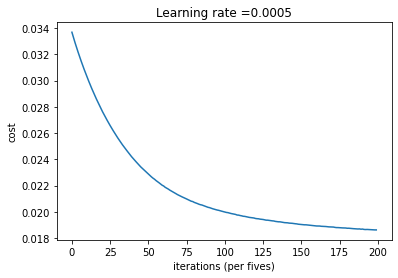

Parameters have been trained!
Train Accuracy: 0.79581666
Test Accuracy: 0.7334


In [91]:
parameters = model_nn(X_train, Y_train_nn, X_test, Y_test)

(784, 60000)
Cost after epoch 0: 0.033686
Cost after epoch 100: 0.026062
Cost after epoch 200: 0.020953
Cost after epoch 300: 0.017492
Cost after epoch 400: 0.015126
Cost after epoch 500: 0.013493
Cost after epoch 600: 0.012322
Cost after epoch 700: 0.011491
Cost after epoch 800: 0.010832
Cost after epoch 900: 0.010331


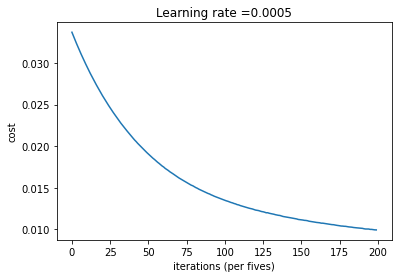

Parameters have been trained!
Train Accuracy: 0.77555
Test Accuracy: 0.7679


In [92]:
parameters_hard = model_nn(X_train, Y_train, X_test, Y_test)